## Table of Contents
<br>

* [Data Cleaning](#Data-Cleaning) 
<br>
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    * [Demographic Factors (age, marriage, job, education)](#Do-demographic-factors-such-as-the-level-of-education,-marital-status,-and-type-of-job-affect-the-success-of-the-marketing-campaign?)
    
    * [Previous banking behaviour (loan, default)](#Does-a-customer’s-previous-banking-behaviour-such-as-taking-out-a-loan,-or-defaulting-impact-their-decision-on-whether-to-subscribe-to-the-term-deposit-or-not?)
    
    * [Marketing campaign details (month of contact)](#Does-the-time-period-in-which-the-customer-is-contacted-increase-the-effectiveness-of-the-campaign?)
<br>    
* [Classification Models](#Classification-Models)
    * [Logistic Regression](#1.-Logistic-Regression)   
    * [Decision Tree](#2.-Decision-Tree)
    * [Random Forest](#3.-Random-Forest)
    * [XGBoost](#4.-XGBoost)
<br>
* [Performance Evaluation](#Performance-Evaluation)     


In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFECV

from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

import xgboost as xgb
import squarify
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

The 'Bank marketing' dataset contains the results of a telemarketing campaign for a Portuguese bank, regarding whether the contacted clients subscribed to a term deposit or not, based on a number of features including customer demographics and more. 
<br>

Source (UCI machine learning repositary) - https://archive.ics.uci.edu/ml/datasets/bank+marketing

In [2]:
#importing the dataset 
df = pd.read_csv("bank-full.csv", delimiter = ";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Data Cleaning

In [140]:
df.shape

(45211, 17)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [142]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


**Missing values**

In [143]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There are no missing values in the dataset

**Distribution of the target variable**

In [144]:
df["y"].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

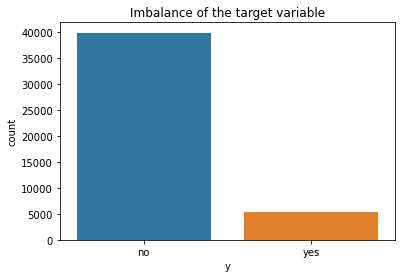

Proportion of observations that were successful:  11.7 %


In [146]:
plt.figure(figsize=(6,4))
sns.countplot(x="y", data=df)
plt.title("Imbalance of the target variable")
plt.show()

print("Proportion of observations that were successful: ", 
     round(df['y'].value_counts()[1] / (df['y'].value_counts()[0] + df['y'].value_counts()[1]) *100, 2), "%")

The target variable is highly imbalanced which would cause bias and inaccuracy in the results. 

**Outliers**

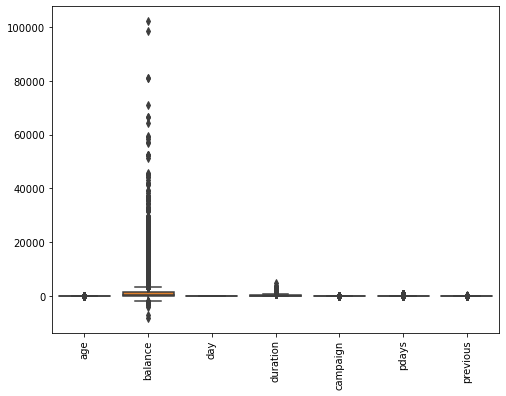

In [148]:
plt.figure(figsize=(8,6))
sns.boxplot(data = df)
plt.xticks(rotation = 90)
plt.show()

In [152]:
#removing the outliers

outliers_list = []
for feature in df.keys():
    
    if df[feature].dtype != "object":
    
        # Calculate Q1 (25th percentile) for each feature
        Q1 = np.percentile(df[feature], 25)

        # Calculate Q3 (75th percentile) for each feature
        Q3 = np.percentile(df[feature], 75)

        # Using 1.5* Interquartile range to define the upper and lower boundaries
        step = (Q3 - Q1) * 1.5

duplicate_outliers_list = list(set([x for x in outliers_list if outliers_list.count(x) >= 2]))
duplicate_outliers_list.sort()

outliers  = duplicate_outliers_list

# Remove the outliers
df = df.drop(df.index[outliers]).reset_index(drop = True)

print("Number of outliers in the data that was removed: ", len(outliers))

Number of outliers in the dataset: 0


**Relationship between variables**

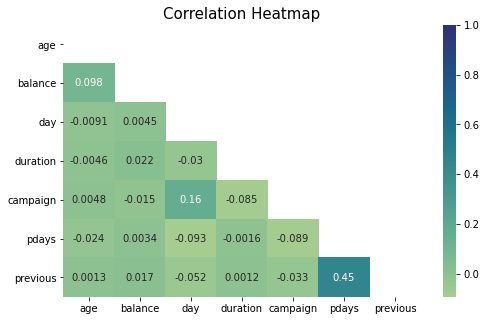

In [153]:
#correlation heatmap for the numerical variables

plt.figure(figsize = (8,5))

mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), annot = True, 
            mask=mask, cmap = "crest", vmax = 1)

plt.title('Correlation Heatmap', fontsize = 15)

plt.show()

There is no sign of multicollinearity in the data

### Exploratory Data Analysis

#### Do demographic factors such as the level of education, marital status, and type of job affect the success of the marketing campaign? 

##### Age

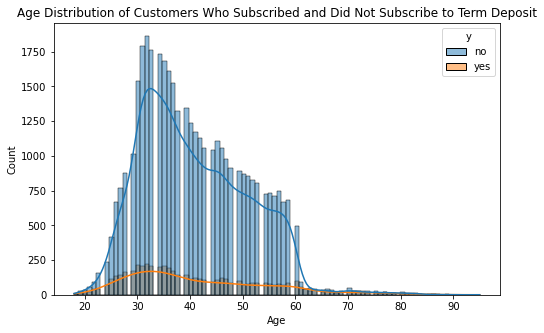

Average age of customers: 
 y
no     40.838986
yes    41.670070
Name: age, dtype: float64


In [154]:
# Plotting a histogram of age distribution for customers
plt.figure(figsize = (8,5))
sns.histplot(data=df, x='age', hue='y', kde=True)

plt.title('Age Distribution of Customers Who Subscribed and Did Not Subscribe to Term Deposit')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


print("Average age of customers: \n",  
      df.groupby('y')['age'].mean())

> - The mean age is 40-42 for both categories
> - It seems that there is no distinct relationship between the age of the clients and whether or not they subscribed to the term deposit. 

##### Job Type

In [155]:
# Finding the percentage of subscribers by their type of job
job = pd.crosstab(df['job'], df['y'], normalize='index')

job_sorted = job.copy()
job_sorted['% subscribed'] = job_sorted['yes'] / (job_sorted['yes'] + job_sorted['no']) * 100
job_sorted = job_sorted.sort_values('% subscribed', ascending=False)


job_sorted

y,no,yes,% subscribed
job,,,
student,0.713220,0.286780,28.678038
retired,0.772085,0.227915,22.791519
unemployed,0.844973,0.155027,15.502686
management,0.862444,0.137556,13.755551
admin.,0.877973,0.122027,12.202669
self-employed,0.881571,0.118429,11.842939
unknown,0.881944,0.118056,11.805556
technician,0.889430,0.110570,11.056996
services,0.911170,0.088830,8.883004


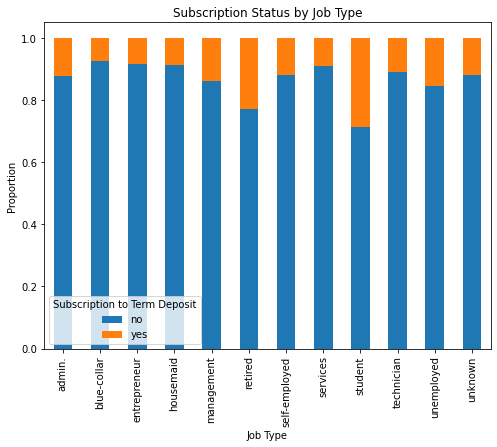

In [156]:
# Plotting a stacked bar chart of subscription status by job type
job.plot(kind='bar', stacked=True)

plt.title('Subscription Status by Job Type')
plt.xlabel('Job Type')
plt.ylabel('Proportion')
plt.legend(title='Subscription to Term Deposit')

plt.show()

> - **Students** and **retired** customers are the ones that are most likely to subscribe to the term deposit based on the marketing campaign. 
> - This is followed by customers who are unemployed and those from the job cadres of management and admin. 
> - Customers from the job cadres of **blue-collar, entreprenuer, and housemaid** are the least likely to subscribe to the bank's term deposit. 

##### Marital Status

In [157]:
# Finding the percentage of subscribers by their marital status
marital = pd.crosstab(df['marital'], df['y'])

marital['% subscribed'] = marital['yes'] / (marital['yes'] + marital['no']) * 100
marital_sorted = marital.sort_values('% subscribed', ascending=False)

marital_sorted

y,no,yes,% subscribed
marital,,,
single,10878,1912,14.949179
divorced,4585,622,11.945458
married,24459,2755,10.123466


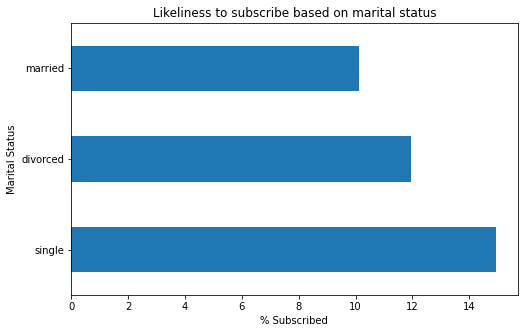

In [330]:
# Plotting the percentage of subscribers by marital status
plt.figure(figsize=(8,5))
ax = marital_sorted['% subscribed'].plot(kind='barh')

ax.set_xlabel('% Subscribed')
ax.set_ylabel('Marital Status')
plt.title('Likeliness to subscribe based on marital status')

#plt.savefig("Classification-Marital.png")
plt.show()

> - Customers who are **single** are most likely to subscribe to the term deposit. 
> - Customers who are **married** are the least likely to subscribe to the term deposit. 

##### Level of Education

In [159]:
# Finding the percentage of subscribers based on level of education
edu = pd.crosstab(df['education'], df['y'])

edu['% subscribed'] = edu['yes'] / (edu['yes'] + edu['no']) * 100
edu_sorted = edu.sort_values('% subscribed', ascending=False)

edu_sorted

y,no,yes,% subscribed
education,,,
tertiary,11305,1996,15.006390
unknown,1605,252,13.570275
secondary,20752,2450,10.559435
primary,6260,591,8.626478


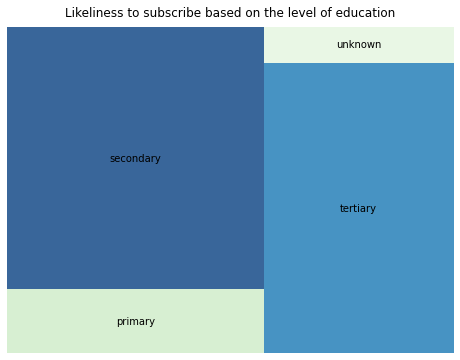

In [329]:
subscribers_by_edu = df[df['y'] == 'yes'].groupby('education')['y'].count()

# Plotting a treemap for the number of customers who subscribed based on level of education
plt.figure(figsize=(8, 6))
colors = plt.cm.GnBu(subscribers_by_edu / float(max(subscribers_by_edu)))
squarify.plot(sizes=subscribers_by_edu, label=subscribers_by_edu.index, color=colors, alpha=0.8)

plt.title("Likeliness to subscribe based on the level of education", pad=10)

plt.axis('off')
#plt.savefig("Classification-Education.png")
plt.show()

> - Customers who have an education of **tertiary and secondary** level are the most likely to subscribe to the term deposit. 
> - Customers with a **primary** education level are not very likely to subscribe. 

#### Does a customer’s previous banking behaviour such as taking out a loan, or defaulting impact their decision on whether to subscribe to the term deposit or not?

##### Loan Status

Index: <br>
loan - Personal loan <br>
housing - Housing loan

In [161]:
#finding the percentage of subscribers based on whether they have a personal or housing loan
loan = pd.crosstab(df['loan'], df['y'], normalize='index')
house = pd.crosstab(df['housing'], df['y'], normalize='index')

loan['% subscribed'] = loan['yes'] / (loan['yes'] + loan['no']) * 100
house['% subscribed'] = house['yes'] / (house['yes'] + house['no']) * 100

display(house)
display(loan)

y,no,yes,% subscribed
housing,,,
no,0.832976,0.167024,16.702355
yes,0.923000,0.077000,7.699960


y,no,yes,% subscribed
loan,,,
no,0.873443,0.126557,12.655727
yes,0.933186,0.066814,6.681391


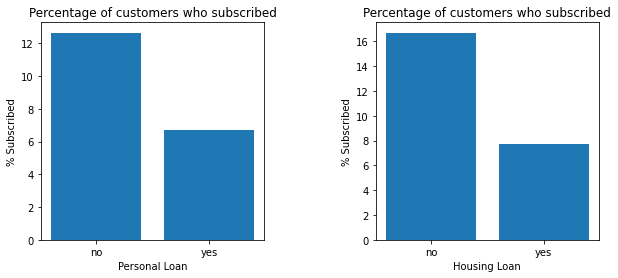

In [162]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Plot the percentage of subscribers by loan category
ax[0].bar(loan.index, loan['% subscribed'])
ax[0].set_xlabel('Personal Loan')
ax[0].set_ylabel('% Subscribed')
ax[0].set_title('Percentage of customers who subscribed')

# Plot the percentage of subscribers by housing category
ax[1].bar(house.index, house['% subscribed'])
ax[1].set_xlabel('Housing Loan')
ax[1].set_ylabel('% Subscribed')
ax[1].set_title('Percentage of customers who subscribed')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5)

# Display the plot
plt.show()


> Customers who **hadn't taken out a loan** (personal and housing) were more likely to subscribe to the bank's term deposit than those who had loans.

##### Default Status

In [163]:
#Finding the percentage of customers who subscribed based on their default status
default = pd.crosstab(df['default'], df['y'], normalize = 'index')
default['% subscribed'] = default['yes'] / (default['yes'] + default['no']) * 100

default

y,no,yes,% subscribed
default,,,
no,0.882039,0.117961,11.796108
yes,0.936196,0.063804,6.380368


> The customers who have defaulted on previous credits are less likely to subscribe to the term deposit. 

#### Does the time period in which the customer is contacted increase the effectiveness of the campaign?

#### Month of contact

In [164]:
# Percentage of customers who subscribed based on the month they were contacted
month = pd.crosstab(df['month'], df['y'], normalize ='index')

month_sorted = month.copy()
month_sorted['% subscribed'] = month_sorted['yes'] / (month_sorted['yes'] + month_sorted['no']) * 100
month_sorted = month_sorted.sort_values('% subscribed', ascending=False)

month_sorted

y,no,yes,% subscribed
month,,,
mar,0.480084,0.519916,51.991614
dec,0.532710,0.467290,46.728972
sep,0.535406,0.464594,46.459413
oct,0.562331,0.437669,43.766938
apr,0.803206,0.196794,19.679400
feb,0.833522,0.166478,16.647792
aug,0.889867,0.110133,11.013286
jun,0.897772,0.102228,10.222805
nov,0.898489,0.101511,10.151134


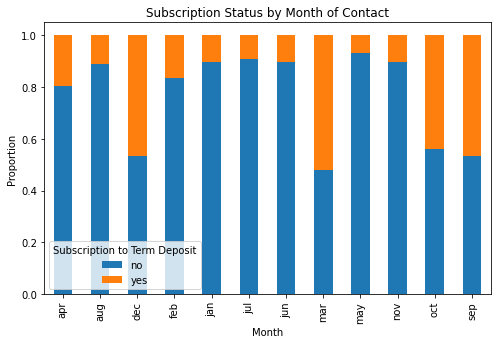

In [328]:
# Plotting a stacked bar chart of subscription status by month of contact

month.plot(kind='bar', stacked=True, figsize=(8, 5))

plt.title('Subscription Status by Month of Contact')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.legend(title='Subscription to Term Deposit')

#plt.savefig("Classification-Month of contact.png")
plt.show()

> - The months of **March, December, September and October** have produced the highest success rates for the marketing campaign indicating that these are the best months to contact the clients. 
> - The least success rates are in the months of **May and July**. 

### Data Preprocessing

In [332]:
#mapping the boolean values

df["y"] = df["y"].map({"yes":1, "no":0})
df["housing"] = df["housing"].map({"yes":1, "no":0})
df["loan"] = df["loan"].map({"yes":1, "no":0})

In [333]:
#dropping the duration variable

df.drop('duration', axis=1, inplace=True)

In [334]:
#Encoding the categorical features

df = pd.get_dummies(df)

In [335]:
#seperating the target variable

x = df.drop("y", axis = 1)
y = df["y"]

In [336]:
#splitting the data into training and testing sets

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 21)

#### Resampling the data

Since the target class is highly imbalanced the training data is resampled. <br>
A combination of under and over sampling has been used using the SMOTE Tomek technique. 

In [337]:
smt = SMOTETomek(sampling_strategy='auto', random_state = 42)
x_bal, y_bal = smt.fit_resample(x_train, y_train)

Counter(y_bal)

Counter({0: 27010, 1: 27010})

##### Feature Selection

Feature Selection has been performed for each model using the recursive feature elimination method, with cross validation.

### Classification Models

In [177]:
#defining a function to evaluate the model performance

def evaluate(model, x_test, y_test):
    
    pred = model.predict(x_test)
    y_score = model.predict_proba(x_test)
    
    accuracy = metrics.accuracy_score(y_test, pred)
    precision = metrics.precision_score(y_test, pred, average='macro')
    recall = metrics.recall_score(y_test, pred, average='macro')
    f1 = metrics.f1_score(y_test, pred, average='macro')
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred).ravel()
    roc_auc = metrics.roc_auc_score(y_test, y_score[:, 1])
    
    print("TN: {}   FP: {}\nFN: {}   TP: {}".format(tn, fp, fn, tp))
    print(metrics.classification_report(y_test, pred))
    print('Accuracy: %f' % accuracy)
    print('Precision: %f' % precision)
    print('Recall: %f' % recall)
    print('F1 score: %f' % f1)
    print('ROC-AUC: %f' % roc_auc)
    
    #plot the roc-auc curve
    plt.figure(figsize = (6,4))
    metrics.plot_roc_curve(model, x_test, y_test)
    plt.plot([0, 1], [0, 1],'r--')
    plt.show()
    
    

#### 1. Logistic Regression

In [183]:
#feature selection and initial fit

lr = linear_model.LogisticRegression()

rfecv = RFECV(estimator=lr, 
              step=1, 
              cv=5)
rfecv.fit(x_bal, y_bal)
print("Optimum number of features: %d" % rfecv.n_features_)

mask = rfecv.get_support()
features = np.array(x_bal.columns) 
best_features = features[mask]

best_features

Optimum number of features: 37


array(['job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'month_apr', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_unknown'],
      dtype=object)

TN: 11821   FP: 187
FN: 1253   TP: 303
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     12008
           1       0.62      0.19      0.30      1556

    accuracy                           0.89     13564
   macro avg       0.76      0.59      0.62     13564
weighted avg       0.87      0.89      0.87     13564

Accuracy: 0.893837
Precision: 0.761264
Recall: 0.589579
F1 score: 0.619388
ROC-AUC: 0.756603


<Figure size 432x288 with 0 Axes>

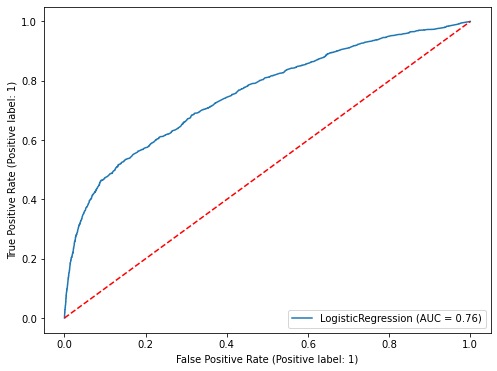

In [184]:
#fitting the model only with the selected features

x_train_rfe = x_bal[best_features]
x_test_rfe = x_test[best_features]

lr.fit(x_train_rfe, y_bal)
evaluate(lr, x_test_rfe, y_test)

#### 2. Decision Tree

In [186]:
#feature selection and initial fit

dt = DecisionTreeClassifier(random_state=42)

rfecv = RFECV(estimator=dt, 
              step=1, 
              cv=5)
rfecv.fit(x_bal, y_bal)
print("Optimum number of features: %d" % rfecv.n_features_)

mask = rfecv.get_support()
features = np.array(x_bal.columns) 
best_features = features[mask]

best_features

Optimum number of features: 46


array(['age', 'balance', 'housing', 'loan', 'day', 'campaign', 'pdays',
       'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'default_no', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'month_apr', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

TN: 10701   FP: 1307
FN: 1038   TP: 518
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     12008
           1       0.28      0.33      0.31      1556

    accuracy                           0.83     13564
   macro avg       0.60      0.61      0.60     13564
weighted avg       0.84      0.83      0.83     13564

Accuracy: 0.827116
Precision: 0.597706
Recall: 0.612030
F1 score: 0.603834
ROC-AUC: 0.612030


<Figure size 432x288 with 0 Axes>

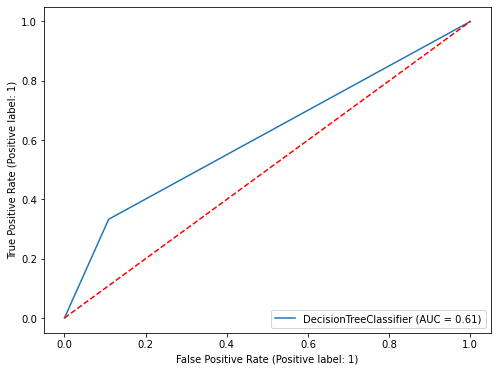

In [187]:
#fitting the model only with the selected features

x_train_rfe = x_bal[best_features]
x_test_rfe = x_test[best_features]

dt.fit(x_train_rfe, y_bal)
evaluate(dt, x_test_rfe, y_test)

##### Hyper-parameter Tuning

Fitting 5 folds for each of 10 candidates, totalling 50 fits
DecisionTreeClassifier(max_features=5, min_samples_leaf=4, random_state=42)
TN: 11258   FP: 750
FN: 1136   TP: 420
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     12008
           1       0.36      0.27      0.31      1556

    accuracy                           0.86     13564
   macro avg       0.63      0.60      0.62     13564
weighted avg       0.85      0.86      0.85     13564

Accuracy: 0.860955
Precision: 0.633659
Recall: 0.603732
F1 score: 0.615428
ROC-AUC: 0.700852


<Figure size 432x288 with 0 Axes>

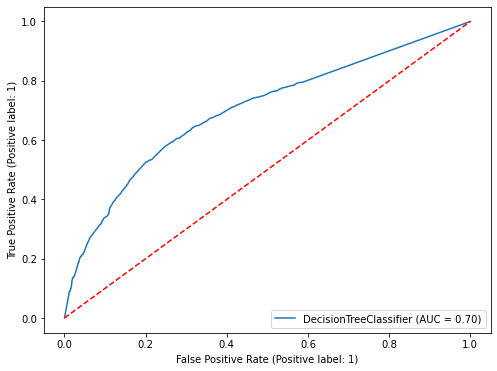

In [188]:
param = {"max_depth": [3, None],
              "max_features": [1,2,3,4,5],
              "min_samples_leaf": [1,2,3,4,5],
              "criterion": ["gini", "entropy"]}

dt_rs = RandomizedSearchCV(estimator=dt, param_distributions=param, 
                           cv=5, verbose=2, n_jobs=-1)

dt_rs.fit(x_train_rfe, y_bal)
print(dt_rs.best_estimator_)

dt_cv = dt_rs.best_estimator_

evaluate(dt_cv, x_test_rfe, y_test)

There has been an improvement following hyper-parameter tuning

#### 3. Random Forest

In [190]:
#feature selection and inital fit

rf = RandomForestClassifier(random_state =42)
rfecv = RFECV(estimator=rf, 
              step=1, 
              cv=5)
rfecv.fit(x_bal, y_bal)
print("Optimum number of features: %d" % rfecv.n_features_)

mask = rfecv.get_support()
features = np.array(x_bal.columns) 
best_features = features[mask]

best_features

Optimum number of features: 38


array(['age', 'balance', 'housing', 'loan', 'day', 'campaign', 'pdays',
       'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_management', 'job_self-employed', 'job_services',
       'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'contact_cellular', 'contact_telephone', 'contact_unknown',
       'month_apr', 'month_aug', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_may', 'month_nov', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype=object)

TN: 11600   FP: 408
FN: 1092   TP: 464
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12008
           1       0.53      0.30      0.38      1556

    accuracy                           0.89     13564
   macro avg       0.72      0.63      0.66     13564
weighted avg       0.87      0.89      0.88     13564

Accuracy: 0.889413
Precision: 0.723036
Recall: 0.632112
F1 score: 0.660739
ROC-AUC: 0.772304


<Figure size 432x288 with 0 Axes>

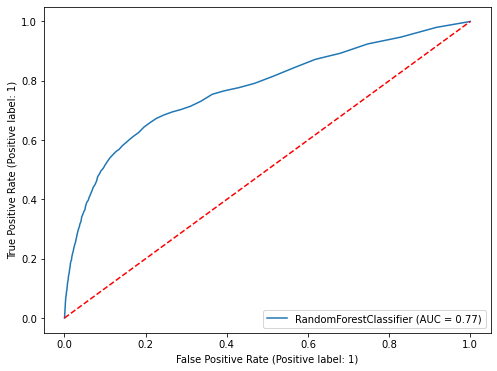

In [191]:
#fitting the models only with the selected features

x_train_rfe = x_bal[best_features]
x_test_rfe = x_test[best_features]

rf.fit(x_train_rfe, y_bal)
evaluate(rf, x_test_rfe, y_test)

##### Hyper-parameter Tuning

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestClassifier(max_features='log2', random_state=42)
TN: 11605   FP: 403
FN: 1084   TP: 472
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12008
           1       0.54      0.30      0.39      1556

    accuracy                           0.89     13564
   macro avg       0.73      0.63      0.66     13564
weighted avg       0.87      0.89      0.88     13564

Accuracy: 0.890372
Precision: 0.727000
Recall: 0.634890
F1 score: 0.664054
ROC-AUC: 0.770588


<Figure size 432x288 with 0 Axes>

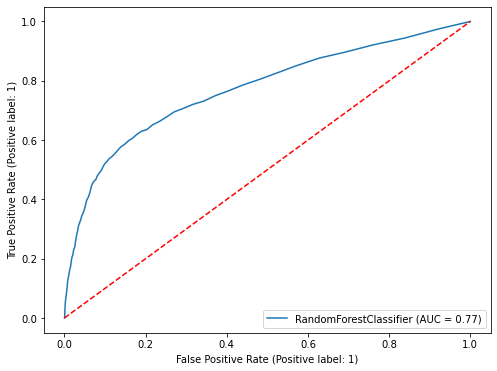

In [192]:
param = { 
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [2,3,4,5, None],
'criterion' :['gini', 'entropy'],
'min_samples_leaf': [1,2,3,4,5]
             }

rf_rs = RandomizedSearchCV(estimator=rf, param_distributions=param, 
                           cv=5, verbose=2, n_jobs=-1)

rf_rs.fit(x_train_rfe, y_bal)
print(rf_rs.best_estimator_)

rf_cv = rf_rs.best_estimator_

evaluate(rf_cv, x_test_rfe, y_test)

There has been an improvement after hyper-parameter tuning

##### Feature Importance

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf_cv.feature_importances_, index=x_train_rfe.columns).sort_values(ascending=False)

# Plot a simple bar chart
#plt.figure(figsize=(6,4))
feature_importances.plot.bar()
plt.show()


#### 4. XGBoost

In [ ]:
xg = xgb.XGBClassifier(objective = "binary:logistic", missing = 1, seed = 42)
xg.fit(x_bal, y_bal, verbose = True, early_stopping_rounds = 10, 
      eval_metric = "aucpr", 
      eval_set = [(x_test, y_test)])

evaluate(xg, x_test, y_test)

In [194]:
#feature selection and inital fit

xg = xgb.XGBClassifier(objective = "binary:logistic", missing = 1, seed = 42)

rfecv = RFECV(estimator=xg, 
              step=1, 
              cv=5)
rfecv.fit(x_bal, y_bal)
print("Optimum number of features: %d" % rfecv.n_features_)

mask = rfecv.get_support()
features = np.array(x_bal.columns) 
best_features = features[mask]

best_features

Optimum number of features: 40


array(['housing', 'loan', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'month_apr', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

TN: 11625   FP: 383
FN: 1110   TP: 446
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12008
           1       0.54      0.29      0.37      1556

    accuracy                           0.89     13564
   macro avg       0.73      0.63      0.66     13564
weighted avg       0.87      0.89      0.87     13564

Accuracy: 0.889929
Precision: 0.725418
Recall: 0.627368
F1 score: 0.656832
ROC-AUC: 0.759436


<Figure size 432x288 with 0 Axes>

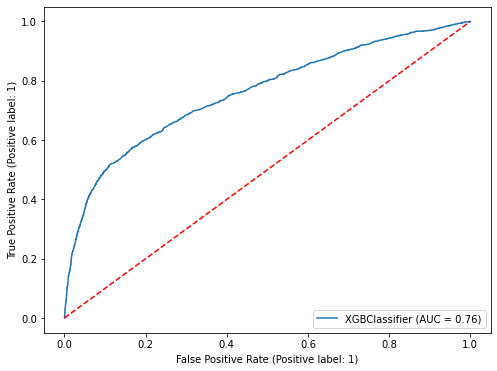

In [195]:
#fitting the model only with the selected features
x_train_rfe = x_bal[best_features]
x_test_rfe = x_test[best_features]

xg.fit(x_train_rfe, y_bal)
evaluate(xg, x_test_rfe, y_test)

##### Hyper-parameter Tuning

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.2, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=1, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
TN: 11679   FP: 329
FN: 1141   TP: 415
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12008
           1       0.56      0.27      0.36   

<Figure size 432x288 with 0 Axes>

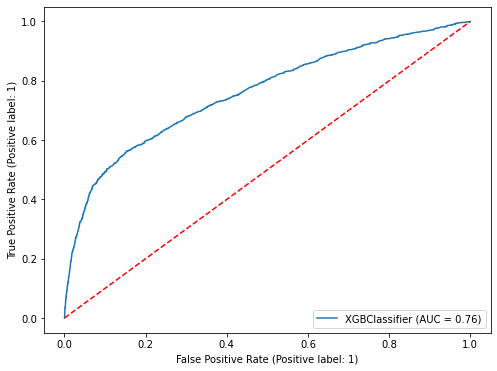

In [197]:
params = { 'max_depth': [3,6],
           'learning_rate': [0.10, 0.20, 0.50],
           'colsample_bylevel': [0.2, 0.3, 0.4]
         }

xg_rs = RandomizedSearchCV(estimator=xg, param_distributions=params,
                           cv = 5, verbose=2, n_jobs=-1)

xg_rs.fit(x_train_rfe, y_bal)
print(xg_rs.best_estimator_)

xg_cv = xg_rs.best_estimator_

evaluate(xg_cv, x_test_rfe, y_test)

There is an improvement following hyper-parameter tuning

##### Feature importance

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(xg_cv.feature_importances_, index=x_train_rfe.columns).sort_values(ascending=False)

# Plot a simple bar chart
#plt.figure(figsize=(6,4))
feature_importances.plot.bar()
plt.show()


### Performance Evaluation

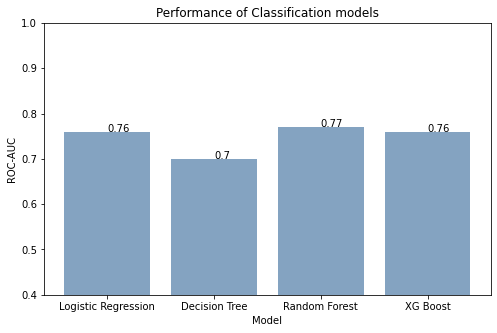

In [339]:
data = {"Logistic Regression": 0.76,
        "Decision Tree": 0.70,
       "Random Forest": 0.77,
       "XG Boost": 0.76}

plt.figure(figsize = (8,5))
plt.bar(list(data.keys()), list(data.values()), color=(0.2, 0.4, 0.6, 0.6))

for i in range(len(data.keys())):
    plt.text(i,list(data.values())[i],list(data.values())[i])

plt.xlabel("Model")
plt.ylabel("ROC-AUC")
plt.ylim(0.4,1)
plt.title("Performance of Classification models")

#plt.savefig("Classification - Performance.png")
plt.show()

The random forest model has the best performance